In [1]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt

class GradientSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.05, epochs=100, random_state=7, verbose=False,
                 lambda_reg=0.0001, patience=10, decay_factor=0.9, min_learning_rate=1e-6,
                 n_control_points=6, smoothing_factor=0.0001, spline_type='cubic', epsilon=1e-4,
                 track_history=False):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type
        self.epsilon = epsilon
        self.track_history = track_history
        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be 'cubic' or 'pchip'")
        np.random.seed(random_state)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = np.mean(X[mask_1], axis=0)
        self.m0 = np.mean(X[~mask_1], axis=0)

    def _initialize_control_points(self, X):
        n_features = X.shape[1] - 1  # Last feature as output
        self.control_x = [np.linspace(X[:, m].min(), X[:, m].max(), self.n_control_points)
                         for m in range(n_features)]
        self.control_y = [np.random.uniform(-0.1, 0.1, self.n_control_points)
                         for m in range(n_features)]
        self.initial_control_x = [cx.copy() for cx in self.control_x]
        self.initial_control_y = [cy.copy() for cy in self.control_y]

    def _fit_spline(self):
        self.splines = [CubicSpline(self.control_x[m], self.control_y[m], bc_type='natural')
                       if self.spline_type == 'cubic'
                       else PchipInterpolator(self.control_x[m], self.control_y[m])
                       for m in range(len(self.control_x))]

    def _calculate_displacement(self, X):
        f_x = np.sum([self.splines[m](X[:, m]) for m in range(len(self.splines))], axis=0)
        return X[:, -1] - f_x

    def _update_pseudo_labels(self, X, y):
        f_m1 = sum(self.splines[m](self.m1[m]) for m in range(len(self.splines)))
        displacement_m1 = self.m1[-1] - f_m1
        self.class_1_pseudo = 1 if displacement_m1 > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def _compute_gradients(self, X, y):
        displacements = self._calculate_displacement(X)
        pseudo_labels = self._update_pseudo_labels(X, y)
        errors = displacements * pseudo_labels <= 0
        error_indices = np.where(errors)[0]

        if len(error_indices) == 0:
            return [np.zeros(self.n_control_points) for _ in range(len(self.splines))]

        X_err = X[error_indices]
        pseudo_labels_err = pseudo_labels[error_indices]
        grad_y = [np.zeros(self.n_control_points) for _ in range(len(self.splines))]

        for m in range(len(self.splines)):
            base_spline_m = self.splines[m](X_err[:, m])
            perturbed_diff_y_m = np.zeros((self.n_control_points, len(error_indices)))

            for j in range(self.n_control_points):
                control_y_pert = self.control_y[m].copy()
                control_y_pert[j] += self.epsilon
                spline_pert = (CubicSpline(self.control_x[m], control_y_pert, bc_type='natural')
                              if self.spline_type == 'cubic'
                              else PchipInterpolator(self.control_x[m], control_y_pert))
                perturbed_diff_y_m[j] = spline_pert(X_err[:, m]) - base_spline_m

            grad_y[m] += np.dot(pseudo_labels_err, perturbed_diff_y_m.T) / self.epsilon

            # Regularization for smoothness
            diff = self.control_y[m][1:] - self.control_y[m][:-1]
            grad_y[m][1:] += 2 * self.lambda_reg * diff
            grad_y[m][:-1] -= 2 * self.lambda_reg * diff

        return grad_y

    def fit(self, X, y):
        if not set(np.unique(y)).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] < 2:
            raise ValueError("Data must have at least 2 features")

        X = np.asarray(X)
        y = np.asarray(y)
        self._calculate_class_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        current_lr = self.initial_learning_rate
        best_error = float('inf')
        best_control_y = [cy.copy() for cy in self.control_y]
        patience_counter = 0

        if self.track_history:
            self.error_history_ = []
            self.control_point_history = [(self.control_x.copy(), [cy.copy() for cy in self.control_y])]

        for epoch in range(self.epochs):
            pseudo_labels = self._update_pseudo_labels(X, y)
            displacements = self._calculate_displacement(X)
            error_count = np.sum(displacements * pseudo_labels <= 0)

            if self.verbose and epoch % 5 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_lr:.6f}")

            if error_count < best_error:
                best_error = error_count
                best_control_y = [cy.copy() for cy in self.control_y]
                self.class_1_pseudo_best = self.class_1_pseudo
                patience_counter = 0
                self.best_epoch = epoch
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_lr = max(current_lr * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_lr == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min learning rate reached at epoch {epoch}")
                        break

            if self.track_history:
                self.error_history_.append(error_count)
                self.control_point_history.append((self.control_x.copy(), [cy.copy() for cy in self.control_y]))

            grad_y = self._compute_gradients(X, y)
            for m in range(len(self.splines)):
                self.control_y[m] -= current_lr * grad_y[m]
            self._fit_spline()

        self.control_y = best_control_y
        self.class_1_pseudo = self.class_1_pseudo_best
        self._fit_spline()
        return self

    def predict(self, X):
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def predict_proba(self, X):
        displacements = self._calculate_displacement(X)
        raw_probs = 1 / (1 + np.exp(-displacements * self.class_1_pseudo * 0.5))
        return np.column_stack([1 - raw_probs, raw_probs]) if self.class_1_pseudo > 0 else np.column_stack([raw_probs, 1 - raw_probs])

    def plot_convergence(self, figsize=(10, 4)):
        if not self.track_history or not hasattr(self, 'error_history_'):
            print("Convergence plotting requires track_history=True and a fitted model.")
            return None
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(self.error_history_, 'b-', label='Errors')
        ax.set_title('Error Convergence')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Number of Errors')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        return fig

    # Plot_boundary omitted as it’s 2D-specific; could adapt for 2D slices if needed

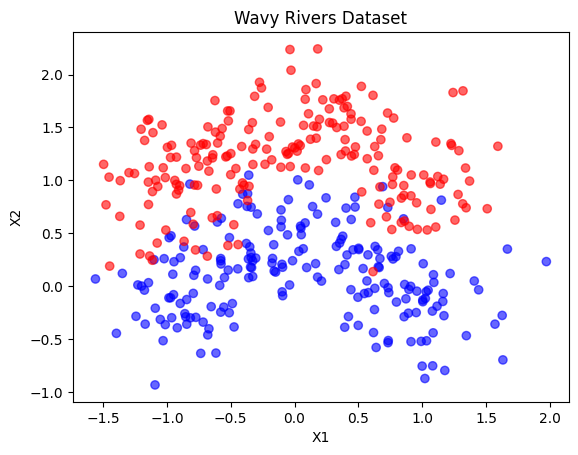

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def make_crescent_waves(n_samples=400, noise=0.3, random_state=42):
    np.random.seed(random_state)
    n = n_samples // 2
    theta = np.random.uniform(0, np.pi, n)

    # Class 0: Lower crescent
    x0 = np.cos(theta) + noise * np.random.randn(n)
    y0 = np.sin(theta) - 0.5 + noise * np.random.randn(n)

    # Class 1: Upper crescent
    x1 = np.cos(theta + np.pi) + noise * np.random.randn(n)
    y1 = -np.sin(theta + np.pi) + 0.5 + noise * np.random.randn(n)

    X = np.vstack((np.column_stack((x0, y0)), np.column_stack((x1, y1))))
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

X, y = make_crescent_waves(n_samples=400)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6)
plt.title("Wavy Rivers Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [5]:
print(y)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 54)

scaler = MinMaxScaler(feature_range=(-100,100))
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 3/5] END epochs=300, epsilon=0.01, lambda_reg=1e-08, learning_rate=0.05, n_control_points=20, spline_type=cubic;, score=0.875 total time=   1.9s
[CV 2/5] END epochs=300, epsilon=0.01, lambda_reg=1e-08, learning_rate=0.05, n_control_points=20, spline_type=cubic;, score=0.953 total time=   1.9s
[CV 5/5] END epochs=300, epsilon=0.01, lambda_reg=1e-08, learning_rate=0.05, n_control_points=20, spline_type=cubic;, score=0.859 total time=   1.9s
[CV 1/5] END epochs=300, epsilon=0.01, lambda_reg=1e-08, learning_rate=0.05, n_control_points=20, spline_type=cubic;, score=0.969 total time=   2.4s
[CV 3/5] END epochs=300, epsilon=0.01, lambda_reg=1e-08, learning_rate=0.05, n_control_points=20, spline_type=pchip;, score=0.891 total time=   2.6s
[CV 2/5] END epochs=300, epsilon=0.01, lambda_reg=1e-08, learning_rate=0.05, n_control_points=30, spline_type=cubic;, score=0.969 total time=   2.7s
[CV 5/5] END epochs=300, epsilon=0.01, lamb

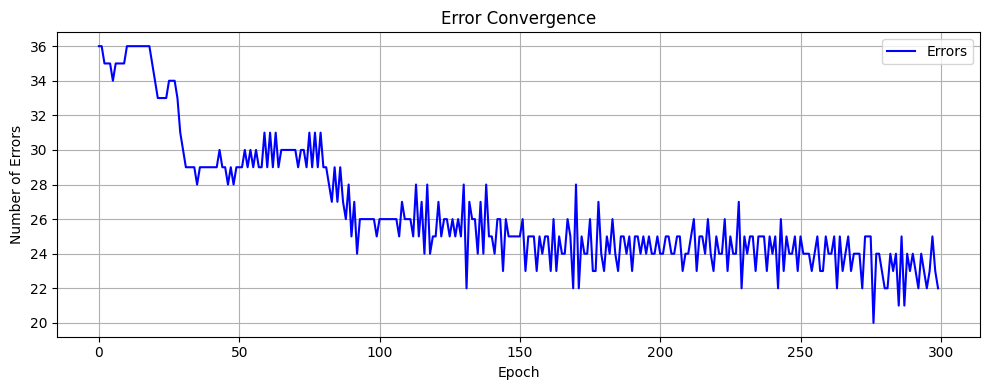

In [7]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],           # Around your 0.1
    'epochs': [300],                   # Bracket your 300
    'n_control_points': [20, 30, 40],            # More points worked for you
    'lambda_reg': [1e-8, 1e-6, 1e-4],           # Ultra-light regularization
    'spline_type': ['cubic', 'pchip'],           # Both options
    'epsilon': [1e-2, 3e-2, 5e-2]               # Around your 0.03
}

# Initialize model with your base settings
smpa = GradientSMPA(
    learning_rate=0.1,        # Moderate step size for gradient updates
    epochs=300,                # Enough iterations to converge
    random_state=99,           # Reproducibility
    verbose=False,              # Track progress
    lambda_reg=0.00000001,
    patience=15,                # Standard patience for LR decay
    decay_factor=0.95,
    min_learning_rate=1e-6,    # Stop when LR gets tiny
    n_control_points=30,        # Flexible but not overkill
    smoothing_factor=0.0000001,      # Your original smoothing, works well
    spline_type='pchip',       # Smooth and differentiable
    epsilon=3.e-2,               # Small perturbation for numerical gradients
    track_history=True
)

# Grid search
grid_search = GridSearchCV(smpa, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 3)
grid_search.fit(X_train_minmax, y_train)

# Results
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

# Test set evaluation
y_pred = grid_search.predict(X_test_minmax)
print("\nGradientSMPA Grid Search Classification Report:")
print(classification_report(y_test, y_pred))

# Plot convergence for best model (after refitting manually if needed)
best_model = grid_search.best_estimator_
fig = best_model.plot_convergence()
plt.show()

In [8]:
test_score = best_model.score(X_test_minmax, y_test)
print("Test score with best model: ", test_score)

Test score with best model:  0.9


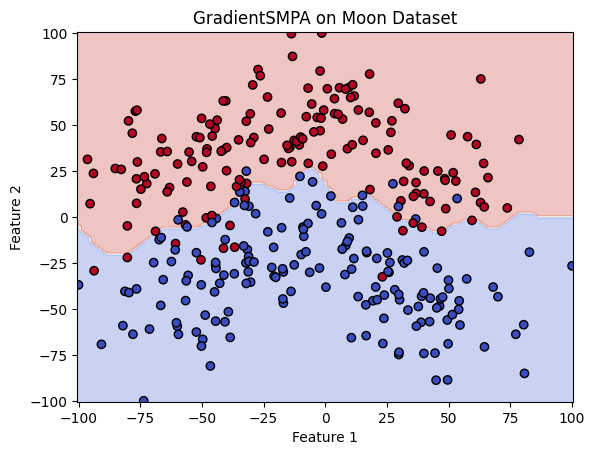

In [9]:
xx, yy = np.meshgrid(np.linspace(X_train_minmax[:,0].min()-0.5, X_train_minmax[:,0].max()+0.5, 100),
                     np.linspace(X_train_minmax[:,1].min()-0.5, X_train_minmax[:,1].max()+0.5, 100))
Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_minmax[:,0], X_train_minmax[:,1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("GradientSMPA on Moon Dataset")
plt.show()

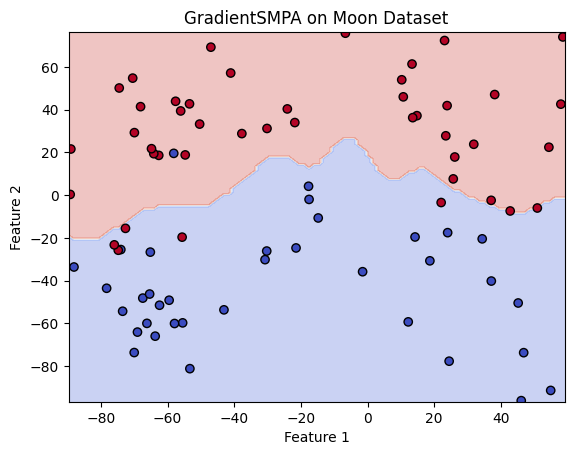

In [10]:
xx, yy = np.meshgrid(np.linspace(X_test_minmax[:,0].min()-0.5, X_test_minmax[:,0].max()+0.5, 100),
                     np.linspace(X_test_minmax[:,1].min()-0.5, X_test_minmax[:,1].max()+0.5, 100))
Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test_minmax[:,0], X_test_minmax[:,1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("GradientSMPA on Moon Dataset")
plt.show()

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf']  # Explicitly set to 'rbf'
}

# Create an instance of SVM
svm = SVC(random_state=42)

# Instantiate the GridSearchCV object:
# - 'svm' is the estimator
# - 'param_grid' defines the parameters to try
# - 'cv=5' means 5-fold cross-validation
# - 'scoring='accuracy'' uses accuracy to compare model performance
# - 'n_jobs=-1' uses all processors for computation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

# Evaluate the best model on the test set
best_model_new = grid_search.best_estimator_
test_score = best_model_new.score(X_test, y_test)
print("Test set score with best model: {:.2f}".format(test_score))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.92
Test set score with best model: 0.86


In [13]:
print("\nClassification Report:")
print(classification_report(y_test, best_model_new.predict(X_test_scaled)))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92        36
         1.0       0.97      0.89      0.93        44

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.92        80
weighted avg       0.93      0.93      0.93        80



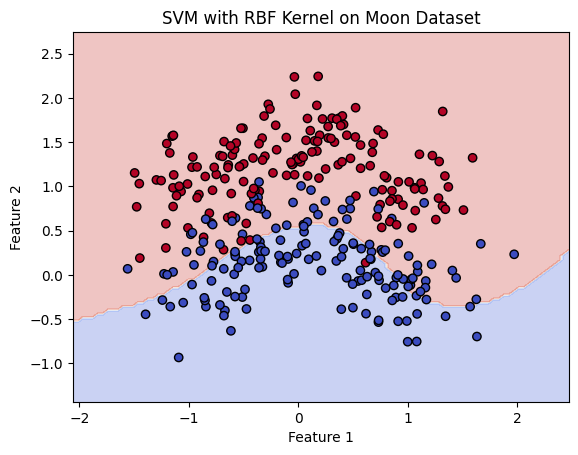

In [14]:
xx, yy = np.meshgrid(np.linspace(X_train[:,0].min()-0.5, X_train[:,0].max()+0.5, 100),
                     np.linspace(X_train[:,1].min()-0.5, X_train[:,1].max()+0.5, 100))
Z = best_model_new.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM with RBF Kernel on Moon Dataset")
plt.show()

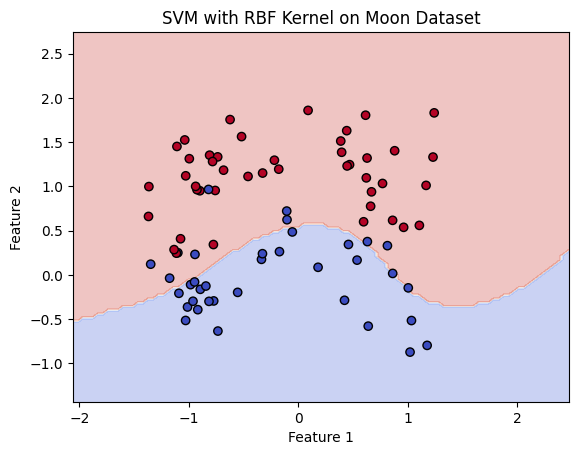

In [15]:
xx, yy = np.meshgrid(np.linspace(X_train[:,0].min()-0.5, X_train[:,0].max()+0.5, 100),
                     np.linspace(X_train[:,1].min()-0.5, X_train[:,1].max()+0.5, 100))
Z = best_model_new.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM with RBF Kernel on Moon Dataset")
plt.show()